# Support vector machines with linear kernels

In this notebook, we'll use a support vector machine (SVM) to classify data by finding a best hyperplane which separates (or approximately separates) two classes. We'll first do it by hand using `cvxpy`, and then use `sklearn`. We'll use data in $\mathbb{R}^2$ so that visualization is easier.

In [2]:
!pip install cvxpy

  Using cached cvxpy-1.3.1-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (4.0 MB)
  Using cached osqp-0.6.2.post8-cp310-cp310-manylinux_2_5_x86_64.manylinux1_x86_64.manylinux_2_17_x86_64.manylinux2014_x86_64.whl (298 kB)
  Using cached ecos-2.0.12-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (220 kB)
  Using cached setuptools-67.6.1-py3-none-any.whl (1.1 MB)
  Using cached scs-3.2.3-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (10.7 MB)
  Using cached qdldl-0.1.7-cp310-cp310-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (1.0 MB)
  Attempting uninstall: setuptools
    Found existing installation: setuptools 65.5.1
    Uninstalling setuptools-65.5.1:
      Successfully uninstalled setuptools-65.5.1


In [1]:
import cvxpy as cp
import numpy as np
import matplotlib.pyplot as plt

## Dataset

We'll use a toy dataset from `sklearn` as a simple example of data in $\mathbb{R}^2$. The `sklearn.datasets` library has many of these useful toy datasets for trying out various machine learning methods. Let's load the "moons" dataset now. 

In [2]:
from sklearn.datasets import make_moons

In [3]:
X, y = make_moons(500, noise=0.1)

In [4]:
X.shape, y.shape

((500, 2), (500,))

We generated 500 data points, each of them a vector of length $2$ and stored in `X`. We also generated labels for each data point stored in `y`. These labels are `0` or `1`, but we will need `1` and `-1`. Here's a quick little trick to fix that.

In [5]:
labels = 2*y - 1

In [6]:
labels

array([-1,  1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,  1, -1, -1,  1,  1,
       -1, -1,  1, -1,  1, -1,  1, -1, -1,  1,  1, -1,  1,  1, -1,  1, -1,
       -1,  1, -1, -1,  1,  1,  1, -1,  1, -1, -1, -1,  1,  1, -1,  1, -1,
        1, -1,  1, -1,  1,  1, -1,  1,  1, -1,  1,  1, -1, -1, -1, -1, -1,
       -1, -1,  1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1,
       -1, -1,  1, -1, -1, -1, -1, -1,  1,  1, -1,  1, -1,  1, -1, -1,  1,
       -1,  1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1,  1,  1,
       -1, -1,  1,  1, -1, -1, -1, -1, -1, -1,  1,  1,  1, -1, -1,  1,  1,
       -1, -1, -1,  1,  1, -1, -1, -1,  1,  1,  1,  1, -1, -1, -1, -1,  1,
        1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1, -1,  1,  1, -1,  1,  1,
        1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1,
       -1,  1, -1,  1,  1,  1,  1,  1,  1,  1, -1,  1,  1, -1,  1, -1,  1,
       -1,  1,  1,  1, -1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1,  1,  1,
        1,  1,  1, -1, -1

Let's plot our data as a scatter plot (we can only do this because it's 2D) and use the labels as our colors.

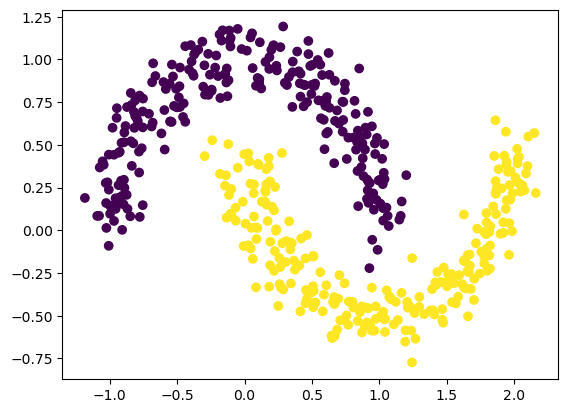

In [7]:
plt.scatter(
    X[:,0], X[:,1],
    c=labels
)

As we can see, the two classes are not linearly separable, so we will have to use a soft margin. Before we set up our optimization problem, let's divide our data into a training and test set. We will only use the _training set_ to fit our model, i.e. to solve the optimization problem.

In [8]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, labels, test_size=0.2)

## SVM by hand with a soft margin

Recall that with a soft margin (using the hinge loss), fitting an SVM amounts to solving the following convex optimization problem:

$$
\min \frac{1}{2} ||w||^2 + C\sum \xi_n
$$

subject to

$$
y_n(\langle w, x_n \rangle + b) \geq 1 - \xi_n,\quad \xi_n \geq 0
$$

Let's use $C=1$ for now. We can set this problem up using `cvxpy`. First, the variables. Carefully check that the dimensions of each is correct.

In [9]:
N = len(X_train)
D = 2
xi = cp.Variable(N)
b = cp.Variable(1)
w = cp.Variable(D)

Now the constraints. To compute all the inner products $\langle w, x_n \rangle$, the easiest is to compute $X^\mathsf{T} w$ where $X^\mathsf{T}$ is the matrix containing the $x_n$ as columns (check this for yourself!). We can then multiply this vector element-wise with $y$. 

Remember, we are only using the training data for this part.

In [10]:
constraints = [
    xi >= 0,
    cp.multiply(y_train,(X_train @ w + b)) >= 1 - xi
]

Finally, we are ready to define the objective function.

In [11]:
C = 1
objective = cp.Minimize(0.5*cp.norm(w)**2 + C*cp.sum(xi))

Let's let `cvxpy` solve the optimization problem and report the values of $w$ and $b$.

In [12]:
prob = cp.Problem(objective, constraints)
prob.solve()

117.45460772262417

In [13]:
w.value, b.value

(array([ 0.78977593, -3.10189408]), array([0.29860536]))

To visualize the output, let's draw the line $\langle w, x \rangle + b = 0$. Writing out this expression we get:
$$
w_1 x_1 + w_2 x_2 = -b \implies x_2 =  -\frac{w_1}{w_2} \cdot x - \frac{b}{w_2}
$$

So let's draw this line by choosing some $x_1$-coordinates (say $-2$ and $3$) and computing the corresponding $x_2$ values. We'll plot it on top of our data.

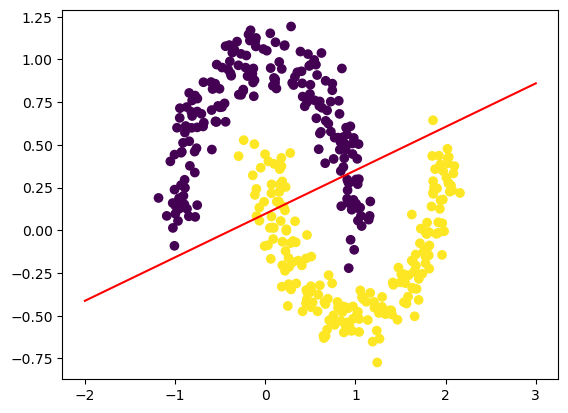

In [15]:
plt.scatter(
    X_train[:,0], X_train[:,1],
    c=y_train
)

line_x1_coords = np.array([-2, 3])
line_x2_coords = -w.value[0]/w.value[1]*line_x1_coords - b.value/w.value[1]
plt.plot(line_x1_coords, line_x2_coords, c='red')

This line is supposed to separate the two classes to the best extend possible. How do you think it did? 

One way to determine how well we did is to compute the accuracy on the test data. Let's do that now. To make a prediction for a new point $x$, we just need to check the sign of $\langle x, w \rangle + b$. Again, we'll compute all the inner products at once using $X^\mathsf{T}w$, except this time the $X$ contains test data not training data.

In [16]:
predictions = np.sign(X_test @ w.value + b.value)

Our accuracy can be obtained by comparing these predictions to the true labels on the test set.

In [17]:
accuracy = sum(predictions == y_test)/len(y_test)
print("Accuracy = ", accuracy)

Accuracy =  0.87


We can also plot the test data with the _predicted labels_ to visualize this accuracy.

Text(0.5, 1.0, 'Predicted labels')

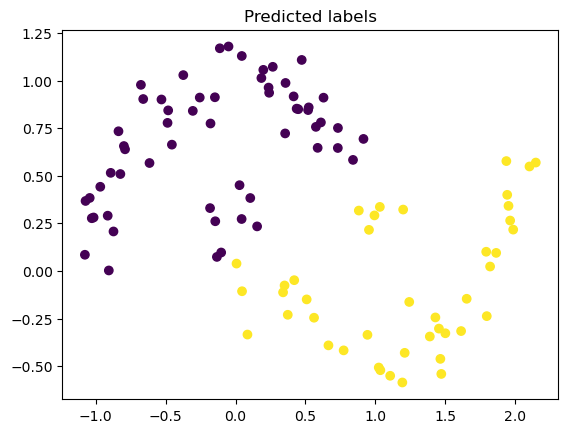

In [18]:
plt.scatter(
    X_test[:,0], X_test[:,1],
    c=predictions
)
plt.title('Predicted labels')

As you can see we did pretty well. Can you spot the dots which were incorrectly classified?

## SVM using `sklearn`

Let's do the same thing as before, but using an off-the-shelf support vector machine from `sklearn`. This will come in handy later when we add more advanced kernels, which will require us only to change a single keyword in our code. See [here](https://scikit-learn.org/stable/modules/generated/sklearn.svm.SVC.html) for the full documentation.

Almost all `sklearn` methods follow a specific pattern. First, you instantiate the method without any data. We will use the `SVC` class (which stands for _support vector classifier_). We call the `sklearn.svm.SVC` method and tell it to use a linear kernel (the kernel we used above based on dot products) and a parameter of $C=1$.

In [19]:
from sklearn.svm import SVC
classifier = SVC(C=1.0, kernel='linear')

We still haven't brought in the data, so let's do that. Most `sklearn` classifier objects have a `fit` method which takes in data and labels. We don't need an `=` symbol as we are just updating the `classifier` object.

In [20]:
classifier.fit(X_train, y_train)

SVC(kernel='linear')

We can now extract parameters as needed. For example, to get the $w$ vector, we look at the `coef_` attribute. To find the $b$ value, we use `intercept_`.

In [21]:
classifier.coef_

array([[ 0.78971166, -3.09942291]])

If everything went according to plan, this should agree with what we got above. It's very easy to use a fitted classifier to predict labels for new data. You can use the `predict` function for this purpose.

In [22]:
classifier.predict(X_test)

array([-1, -1,  1,  1,  1, -1, -1, -1, -1,  1, -1, -1, -1,  1, -1, -1, -1,
        1, -1, -1,  1,  1,  1, -1, -1,  1,  1,  1,  1, -1, -1, -1,  1, -1,
       -1, -1,  1, -1, -1, -1,  1, -1, -1, -1, -1,  1,  1, -1,  1, -1, -1,
        1, -1,  1,  1,  1, -1, -1, -1, -1,  1,  1, -1, -1, -1,  1, -1,  1,
       -1,  1,  1,  1, -1, -1,  1, -1, -1,  1,  1, -1, -1,  1, -1, -1, -1,
        1, -1,  1, -1,  1,  1, -1,  1,  1, -1, -1,  1, -1, -1,  1])

We can use these predicted labels to get our accuracy, or we can just use the handy `score` function.

In [24]:
classifier.score(X_test, y_test)

0.87

Again, we should get the same answer as above for our accuracy.

## Exercise 1

You can use `sklearn` for these exercises.

(a) Report the accuracy of the classifier above on the training data.

(b) Rerun the classifier above with $C = 0.01$ and report the accuracy on the training data.

(c) Rerun the classifier above with $C = 0.001$ and report the accuracy on the training data.

What happens to the accuracy as $C$ decreases? 


In [25]:
X_train.shape

(400, 2)

In [25]:
classifier.score(X_train, y_train)

0.8725

In [26]:
classifier2 = SVC(C=0.01, kernel='linear')

In [28]:
classifier2.fit(X_train, y_train)
classifier2.score(X_train, y_train)

0.8325

In [30]:
classifier3 = SVC(C=0.001, kernel='linear')
classifier3.fit(X_train, y_train)
classifier3.score(X_train, y_train)

0.51

As C decreases, the accuracy decreases in this case. 

## Exercise 2

Make a new dataset which has 10 points with label $-1$ and 100 points with label $1$ using `make_moons` (read the documentation [here](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.make_moons.html) to figure out how to define the number of points in each class). 

(a) Fit the classifer on the whole dataset using $C = 0.1$ and plot the hyperspace as a red line like we did above. Report the accuracy on the dataset.

(b) Fit the classifer on the whole dataset using $C = 1$ and plot the hyperspace as a red line like we did above. Report the accuracy on the dataset.

(c) Fit the classifer on the whole dataset using $C = 100$ and plot the hyperspace as a red line like we did above. Report the accuracy on the dataset.

In [38]:
X2, y2 = make_moons((10,100))
labels2 = 2*y2 - 1
np.count_nonzero(labels == -1), np.count_nonzero(labels2 == 1)

(10, 100)

In [65]:
classifierA = SVC(C=0.1, kernel='linear')
classifierA.fit(X2, y2)

SVC(C=0.1, kernel='linear')

In [57]:
w2 = classifierA.coef_
b2 = classifierA.intercept_
w2, b2

(array([[ 0.02970961, -0.20663488]]), array([1.04389822]))

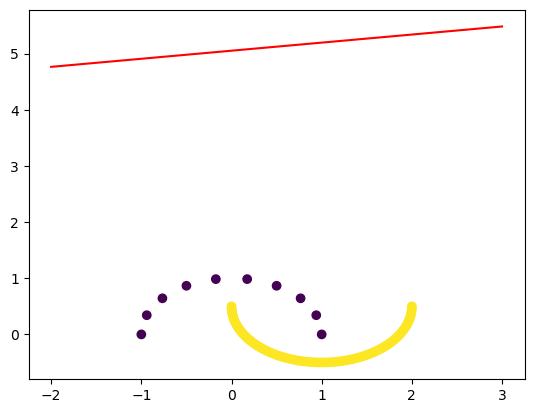

In [58]:
plt.scatter(
    X2[:,0], X2[:,1],
    c=labels2
)
line_x1_coords = np.array([-2, 3])
line_x2_coords = -w2[0][0]/w2[0][1]*line_x1_coords - b2/w2[0][1]
plt.plot(line_x1_coords, line_x2_coords, c='red')

In [66]:
classifierA.score(X2, y2)

0.9090909090909091

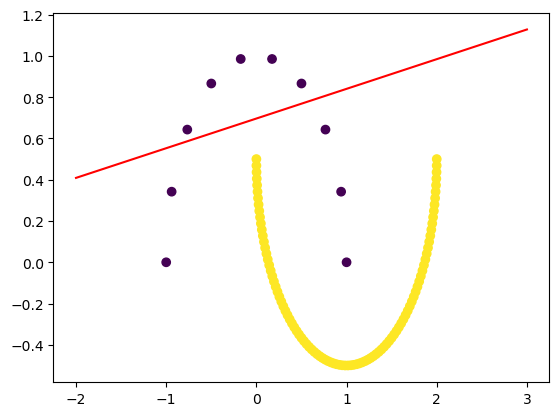

In [61]:
classifierB = SVC(C=1.0, kernel='linear')
classifierB.fit(X2, y2)
w3 = classifierB.coef_
b3 = classifierB.intercept_
plt.scatter(
    X2[:,0], X2[:,1],
    c=labels2
)
line_x1_coords = np.array([-2, 3])
line_x2_coords = -w3[0][0]/w3[0][1]*line_x1_coords - b3/w3[0][1]
plt.plot(line_x1_coords, line_x2_coords, c='red')

In [62]:
classifierB.score(X2, y2)

0.9545454545454546

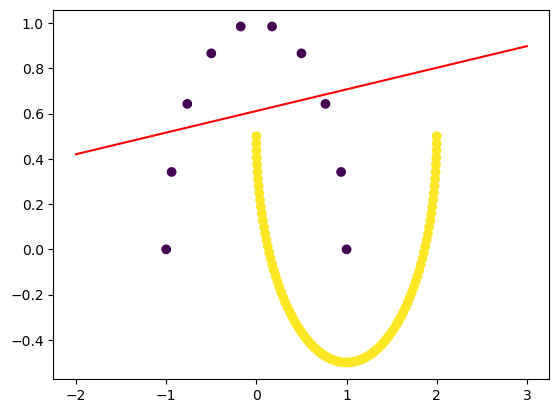

In [63]:
classifierC = SVC(C=100.0, kernel='linear')
classifierC.fit(X2, y2)
w4 = classifierC.coef_
b4 = classifierC.intercept_
plt.scatter(
    X2[:,0], X2[:,1],
    c=labels2
)
line_x1_coords = np.array([-2, 3])
line_x2_coords = -w4[0][0]/w4[0][1]*line_x1_coords - b4/w4[0][1]
plt.plot(line_x1_coords, line_x2_coords, c='red')

In [64]:
classifierC.score(X2, y2)

0.9545454545454546